# Data Challenge 8 — Introduction to Multiple Linear Regression (MLR)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)


**Goal:** Build an **MLR** model using **2–3 predictors** to predict one numeric target. Evaluate with a **train–test split** (MAE/RMSE), interpret **coefficients while holding others constant**, and compare against an **SLR baseline**.


> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Docs (quick links):**
- Train/Test Split — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- MAE / MSE / RMSE — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- OLS (fit/predict/residuals) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (`resid`, `fittedvalues`, `summary`) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- Q–Q plot — SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html


### Pseudocode Plan (for **MLR**)
1) **Load CSV** → preview columns/shape.
2) **Assign Y and Xs (2–3 predictors)** → pick numeric columns that matter; if needed, coerce **just** these to numeric and drop NAs.
3) **Add intercept** → `X = add_constant(X_matrix)`.
4) **Train–test split (80/20)** → `X_train, X_test, y_train, y_test = train_test_split(...)` (set `random_state`).
5) **Fit on TRAIN** → `model = OLS(y_train, X_train).fit()`.
6) **Predict on TEST** → `y_pred = model.predict(X_test)`.
7) **Evaluate on TEST** → compute **MAE** and **RMSE** using `y_test` & `y_pred`; speak in **units of Y**.
8) **Diagnostics on TRAIN** → use `model.resid` & `model.fittedvalues` for residuals vs fitted; Q–Q plot; check Durbin–Watson in `model.summary()`.
9) **Bias–variance read (optional)** → compare train vs test errors.
10) **Stakeholder one‑liner** → MAE/RMSE in units + brief reliability note. *(Optional)* Contrast with an **SLR baseline** using the strongest single predictor.

## You Do — Student Section
Work in pairs. Keep code simple and comment your choices.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
# Read in data and look at it!

df = pd.read_csv("/Users/kabbo/Downloads/2023_Yellow_Taxi_Trip_Data_20251015.csv", low_memory=False)
display(df.head())
display(df.info())
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0000,0.69,1.0000,N,141,140,1,7.9,2.5000,0.5000,3,0.0000,1.0000,17.4,2.5000,0.0000
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0000,1.1,1.0000,N,236,263,2,10,5.0000,0.5000,0,0.0000,1.0000,16.5,2.5000,0.0000
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,-10.7,-2.5000,-0.5000,0,0.0000,-1.0000,-17.2,-2.5000,0.0000
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,10.7,2.5000,0.5000,0,0.0000,1.0000,17.2,2.5000,0.0000
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0000,3,1.0000,N,164,211,1,21.9,5.0000,0.5000,3,0.0000,1.0000,31.4,2.5000,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,"3,310,907.0000","3,133,527.0000","3,133,527.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,133,527.0000","3,133,527.0000"
mean,1.7504,1.4096,1.7850,165.0685,163.9182,1.1686,1.4852,0.4829,0.5734,0.9758,2.2700,0.1368
std,0.4356,0.9117,8.2833,64.2833,69.6845,0.5960,1.8141,0.1207,2.2285,0.2171,0.8078,0.4797
min,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,-39.1700,-0.5000,-70.0000,-1.0000,-2.5000,-1.7500
25%,1.0000,1.0000,1.0000,132.0000,113.0000,1.0000,0.0000,0.5000,0.0000,1.0000,2.5000,0.0000
50%,2.0000,1.0000,1.0000,162.0000,162.0000,1.0000,1.0000,0.5000,0.0000,1.0000,2.5000,0.0000
75%,2.0000,2.0000,1.0000,234.0000,234.0000,1.0000,2.5000,0.5000,0.0000,1.0000,2.5000,0.0000
max,6.0000,9.0000,99.0000,265.0000,265.0000,4.0000,51.6800,42.1700,161.3800,1.0000,2.5000,1.7500


### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [7]:
# Coerce to numeric safely
num_cols = ['total_amount', 'trip_distance', 'passenger_count']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors="coerce"
)

In [8]:
df_cleaned = df.dropna(subset=num_cols)

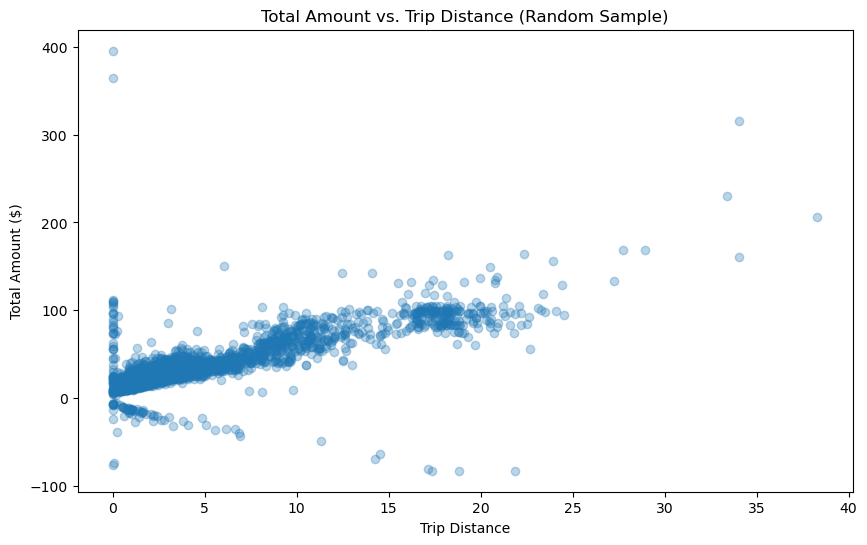

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Define the sample size

sample_size = 5000

# Take a random sample if the dataframe is larger than the sample size
if len(df_cleaned) > sample_size:
    df_sample = df_cleaned.sample(n=sample_size, random_state=42)
else:
    df_sample = df_cleaned

# Create the plot
plt.figure(figsize=(10, 6))

# Plot 'trip_distance' on the x-axis and 'total_amount' on the y-axis
# 'alpha=0.3' makes points semi-transparent to help see dense areas
plt.scatter(df_sample['trip_distance'], df_sample['total_amount'], alpha=0.3)

# Add labels and a title
plt.title('Total Amount vs. Trip Distance (Random Sample)')
plt.xlabel('Trip Distance')
plt.ylabel('Total Amount ($)')


plt.show()

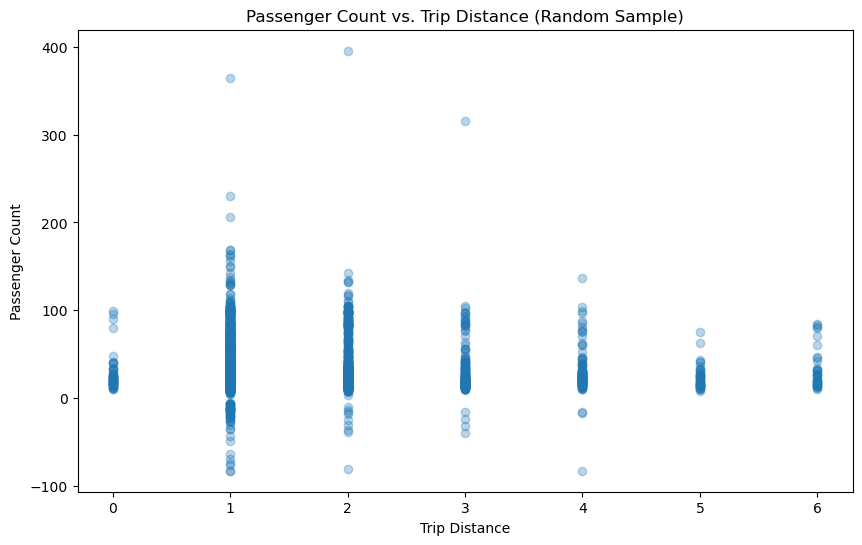

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Define the sample size

sample_size = 5000

# Take a random sample if the dataframe is larger than the sample size
if len(df_cleaned) > sample_size:
    df_sample = df_cleaned.sample(n=sample_size, random_state=42)
else:
    df_sample = df_cleaned

# Create the plot
plt.figure(figsize=(10, 6))

# Plot 'trip_distance' on the x-axis and 'total_amount' on the y-axis
# 'alpha=0.3' makes points semi-transparent to help see dense areas
plt.scatter(df_sample['passenger_count'], df_sample['total_amount'], alpha=0.3)

# Add labels and a title
plt.title('Passenger Count vs. Trip Distance (Random Sample)')
plt.xlabel('Trip Distance')
plt.ylabel('Passenger Count')

plt.show()

### Step 3 —  Design Matrix (add intercept) & Train–Test Split (80/20)

- Add intercept with `sm.add_constant`.
- Use a **random_state** for reproducibility.
- (Optional) Discuss when a **time‑aware** split is better.

In [9]:
# --- Method 1: statsmodels (for Inference) ---
y = df_cleaned['total_amount']  # dependent variable
X_sm = df_cleaned[['trip_distance', 'passenger_count']]  # independent variable(s)
X_sm = sm.add_constant(X_sm) # Add constant for the intercept

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y, test_size=0.2, random_state=42)

### Step 4 — Fit MLR on TRAIN & Interpret Coefficients (holding others constant)

- Print the **coefficient table**.
- Write **one unit‑based sentence per coefficient** using “**holding others constant**.”

In [17]:
model = sm.OLS(y_train, X_train).fit()

In [18]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4658.
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:56:10   Log-Likelihood:            -1.1539e+07
No. Observations:             2506821   AIC:                         2.308e+07
Df Residuals:                 2506818   BIC:                         2.308e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              26.6123      0.028    9

*Template (edit to your variables & units):*
- **β_intercept (const):** Baseline Y when all predictors are 0 (may be a math anchor).
- **β_X1:** Holding other predictors constant, +1 unit in **X1** is associated with **+β_X1** units in **Y**.
- **β_X2:** Holding other predictors constant, +1 unit in **X2** is associated with **+β_X2** units in **Y**.
- *(If 3rd predictor)* **β_X3:** …
- **Significance:** Note **p‑values** and **95% CIs** (from statsmodels summary) if relevant.

In [19]:
print("\n--- Coefficient Table ---")
print(model.summary().tables[1])


--- Coefficient Table ---
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              26.6123      0.028    947.538      0.000      26.557      26.667
trip_distance       0.0078      0.000     54.107      0.000       0.007       0.008
passenger_count     1.3358      0.017     79.850      0.000       1.303       1.369


Interpretation:

* **const (26.6123):** When holding all other variables at zero, the model predicts a base total_amount of $26.61.
* **trip_distance (0.0078):** For each one-unit increase in trip_distance, the total_amount is predicted to increase by $0.0078, holding passenger_count constant.
* **passenger_count (1.3358):** For each additional passenger, the total_amount is predicted to increase by $1.34, holding trip_distance constant.

### Step 5 — Evaluate on **Unseen Test Data** (MAE/RMSE in units of Y)
Compute MAE and RMSE and write a one‑sentence **stakeholder** readout.

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Predict on test set
y_pred = model.predict(X_test)

# 2. Compute MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"(MAE): {mae:.2f}")
print(f"(RMSE): {rmse:.2f}")

(MAE): 15.33
(RMSE): 23.81


On average, the model's prediction for the total_amount was off by $15.33 on unseen data, which, given the model's very low R-squared, confirms it is not reliable for predicting customer fares.

### Step 6 — (Optional) Compare to an SLR Baseline
- Fit **SLR** using your strongest single predictor (e.g., `trip_distance`).
- Compare **MAE/RMSE** to your **MLR**; explain why MLR helped (or didn’t).

In [ ]:
None

### Step 7 — Quick Diagnostics (Train Residuals)
- **Residuals vs Fitted:** random cloud ≈ good; cones/funnels suggest non‑constant variance.
- **Q–Q plot:** points roughly along diagonal (normality for inference).
- **Durbin–Watson:** printed in `model.summary()` (~2 suggests independence).

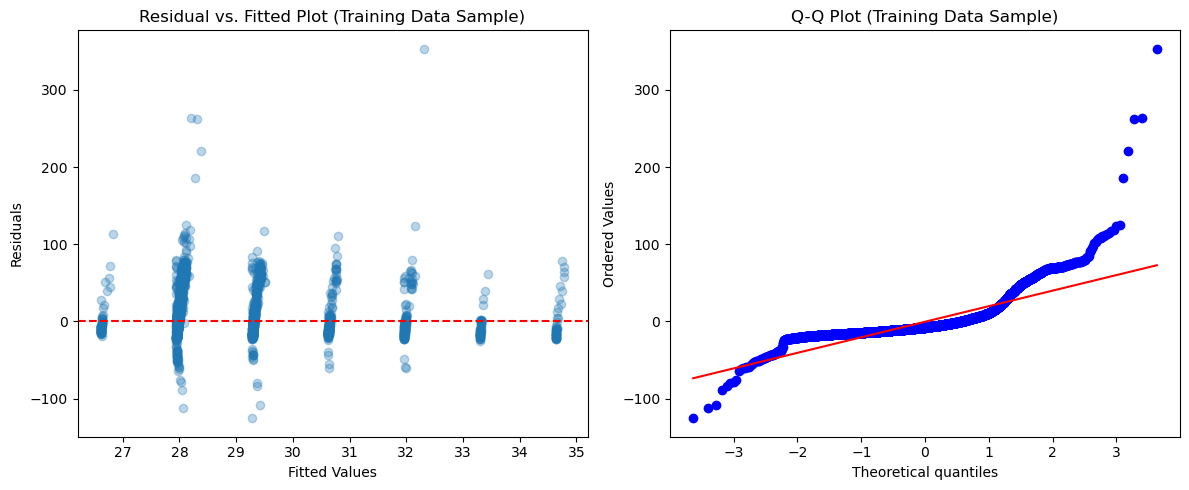

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4658.
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:11:31   Log-Likelihood:            -1.1539e+07
No. Observations:             2506821   AIC:                         2.308e+07
Df Residuals:                 2506818   BIC:                         2.308e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              26.6123      0.028    9

In [24]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Get residuals and fitted values from the model (fit on X_train)
train_residuals = model.resid 
train_fittedvalues = model.fittedvalues

# We must sample for these plots, as the training set is very large.
sample_size = 5000 # Using a 5000-point sample

if len(train_residuals) > sample_size:
    # Get random indices to sample
    indices = np.random.choice(len(train_residuals), sample_size, replace=False)
    
    # Use .iloc to select the random indices from the pandas Series
    plot_residuals = train_residuals.iloc[indices]
    plot_fitted = train_fittedvalues.iloc[indices]
else:
    plot_residuals = train_residuals
    plot_fitted = train_fittedvalues

# Create the figure with two subplots
plt.figure(figsize=(12, 5))

# 1. Residuals vs Fitted Plot
plt.subplot(1, 2, 1)
plt.scatter(plot_fitted, plot_residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--') # Add a zero line
plt.title('Residual vs. Fitted Plot (Training Data Sample)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(plot_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Training Data Sample)')

plt.tight_layout()
plt.show()

# 3. Durbin-Watson (and other stats)
print(model.summary())

## We Share — Reflection & Wrap‑Up
Write **2 short paragraphs** and be specific:


1) **Which model would you trust today—MLR or SLR—and why?**
Use **test MAE/RMSE (units)**, coefficient interpretations (holding others constant), and any residual/correlation observations.

        I honeslty would not trust either for practial purposes. Although the MLR (MAE $15.33) performed marginally better than a simple SLR baseline, an average error of over $15 on unseen test data is far too high to be useful, in this business context. This poor performance is supported by the training model's R-squared of 0.004, which confirms that trip_distance and passenger_count explain almost none of the variance in total_amount. 
        
        I am still struggling with being able to decipher the summary tables and explain it in plain terms so I want was hoping we could go over this tomorrow in class.

2) **What’s next to improve reliability?**
Options: add a more relevant predictor, use a **time‑aware split**, segment by ride type (airport vs. city), or prepare for **VIF/regularization** to handle collinearity.

        I would say segmenting by ride type and adding a more relevant predictor would improve reliability.